#Downloading Dataset

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

--2024-04-13 04:20:50--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  30.7MB/s    in 12s     

2024-04-13 04:21:02 (25.7 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [ ]:
!unzip /content/UCMerced_LandUse.zip

Archive:  /content/UCMerced_LandUse.zip
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural09.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural10.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural11.tif  
  inflating: UCMerc

#Test train split

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data_into_dirs(source_directory, train_directory, test_directory, test_size=0.2, random_state=42):
    """
    Function to split data into train and test directories.
    """
    # Create train and test directories if they don't exist
    if not os.path.exists(train_directory):
        os.makedirs(train_directory)
    if not os.path.exists(test_directory):
        os.makedirs(test_directory)

    # Get subdirectories
    subdirectories = [d for d in os.listdir(source_directory) if os.path.isdir(os.path.join(source_directory, d))]

    # Perform train-test split for each subdirectory
    for subdir in subdirectories:
        subdir_path = os.path.join(source_directory, subdir)
        train_subdir = os.path.join(train_directory, subdir)
        test_subdir = os.path.join(test_directory, subdir)

        # Create train and test subdirectories
        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # Get list of images in subdirectory
        images = [f for f in os.listdir(subdir_path) if f.endswith('.tif')]

        # Perform train-test split
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=random_state)

        # Move images to train and test directories
        for image in train_images:
            shutil.copy(os.path.join(subdir_path, image), os.path.join(train_subdir, image))
        for image in test_images:
            shutil.copy(os.path.join(subdir_path, image), os.path.join(test_subdir, image))

# Set source directory containing subdirectories with TIFF images
source_directory = "/content/UCMerced_LandUse/Images/"

# Set target directories for training and testing data
train_directory = "/content/UCMerced_LandUse/train"
test_directory = "/content/UCMerced_LandUse/test"

# Perform train-test split and move images to respective directories
split_data_into_dirs(source_directory, train_directory, test_directory)

# Print confirmation message
print("Data has been split into training and testing directories.")


Data has been split into training and testing directories.


#Dataloader

In [ ]:

import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

# takes all images and convert them to grayscale.
# return a dictionary that holds all images category by category.
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat,0)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                category.append(img)
        images[filename] = category
    return images


images = load_images_from_folder('/content/UCMerced_LandUse/train')  # take all images category by category
test = load_images_from_folder("/content/UCMerced_LandUse/test") # take test images


#Extracting SIFT features

In [ ]:
import cv2
from tqdm import tqdm

def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key, value in tqdm(images.items(), desc="Processing images"):
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img, None)
            # Check if des is not None
            if des is not None:
                descriptor_list.extend(des)
                features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images)
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0]
# Takes the sift features that is separated class by class for train data
all_bovw_feature = sifts[1]
# Takes the sift features that is separated class by class for test data
test_bovw_feature = sift_features(test)[1]



Processing images: 100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


#Creating BOVW
###Takes around 1.5~2 hrs

In [ ]:
# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words

# Takes the central points which is visual words
visual_words = kmeans(150, descriptor_list)

In [ ]:
np.save("visual_words.npy", visual_words)

visual_wordss = np.load("visual_words.npy")

In [ ]:
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i])
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i])
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [ ]:
from tqdm import tqdm

# Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class
# And the second parameter is an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class.
def image_class(all_bovw, centers):
    dict_feature = {}
    for key, value in tqdm(all_bovw.items(), desc="Creating histograms"):
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

# Creates histograms for train data
bovw_train = image_class(all_bovw_feature, visual_wordss)
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_wordss)


Creating histograms: 100%|██████████| 21/21 [06:04<00:00, 17.37s/it]


#Using SVM classifer and Evaluating

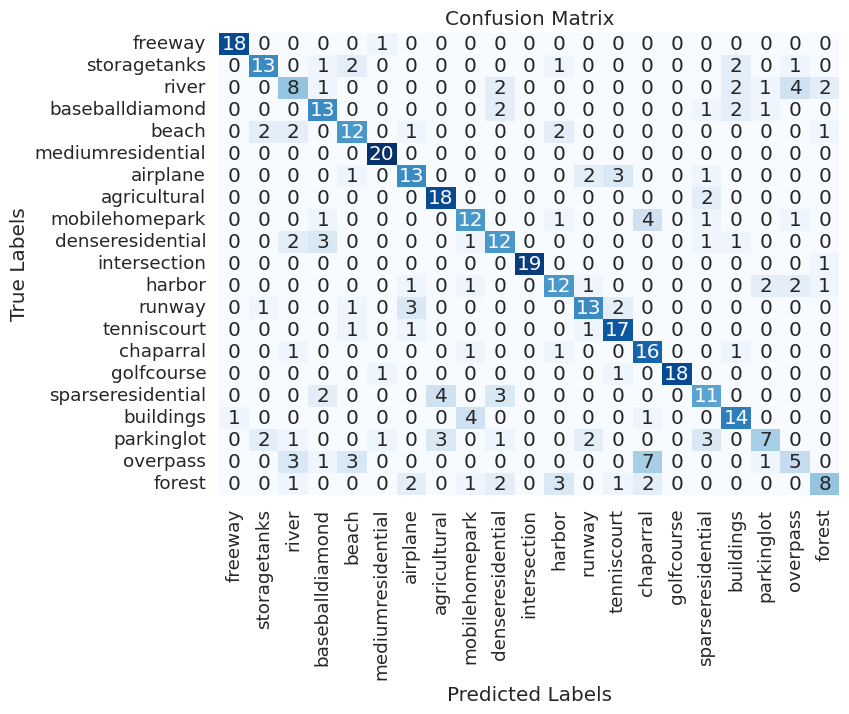

Accuracy: 0.6674641148325359

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.95      0.95      0.95        19
         airplane       0.72      0.65      0.68        20
  baseballdiamond       0.44      0.40      0.42        20
            beach       0.59      0.68      0.63        19
        buildings       0.60      0.60      0.60        20
        chaparral       0.87      1.00      0.93        20
 denseresidential       0.62      0.65      0.63        20
           forest       0.72      0.90      0.80        20
          freeway       0.60      0.60      0.60        20
       golfcourse       0.55      0.60      0.57        20
           harbor       1.00      0.95      0.97        20
     intersection       0.60      0.60      0.60        20
mediumresidential       0.68      0.65      0.67        20
   mobilehomepark       0.71      0.85      0.77        20
         overpass       0.53      0.80      0.64        20
  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def svm_classifier(images, tests):
    # Initialize SVM classifier
    svm = SVC(kernel='linear')  # You can change the kernel type as needed

    train_X = []
    train_y = []

    # Prepare the training data
    for class_label, class_data in images.items():
        for img_features in class_data:
            train_X.append(img_features)
            train_y.append(class_label)

    # Train the SVM classifier
    svm.fit(train_X, train_y)

    # Make predictions
    test_X = []
    true_labels = []
    for class_label, class_data in tests.items():
        for img_features in class_data:
            test_X.append(img_features)
            true_labels.append(class_label)

    predicted_labels = svm.predict(test_X)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    class_labels = list(images.keys())
    plot_confusion_matrix(conf_matrix, class_labels)

    # Calculate classification report
    class_report = classification_report(true_labels, predicted_labels)

    return accuracy, class_report

# Call the SVM classifier function
accuracy, class_report = svm_classifier(bovw_train, bovw_test)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(class_report)
